# Re-doing analysis of first and last day of record for 1998-2020

As the previous analysis has shown (i.e., _2-further-analysis.ipynb_ and _3-first-last-day.ipynb_), the analysis of the first (and last) day of sight was corrupted by the large amount of missing data in the first couple of years. In the following, the procedure is repeated for the period in time ranging from 1998 to 2020. The output figures can be found in the *first-last-day_1998-2020* subdirectory.

In [1]:
# import libraries
from datetime import datetime
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(
    style="darkgrid",
    color_codes=True,
    palette='Dark2',
)

# import (personal) functions & variables
from funcs import import_pickled_data, which_cols, number_of_day_to_date, highlight_years, first_last_day
from vals import sheets
species, species_long, species_summed = import_pickled_data()

### First and last day of record per year

The data is represented in an individual plot for every species.

In [2]:
# update time period from 1998 to 2020
yrs = np.arange(1998, 2020+1)

# compute total number of counts per year per species
total_year = dict()
for s in sheets:
    df = species_summed[s]
    dummy_counts = np.zeros(len(yrs))
    for i in range(len(dummy_counts)):
        dummy_counts[i] = df['count'][df['Year'] == yrs[i]].sum(min_count=1)
    total_year[s] = dummy_counts

In [3]:
# compute first and last day of appearance per species
def first_last_day(df):
    '''
    data frame must have a 'Year' column!
    '''
    first = np.zeros(len(yrs))
    last = np.zeros(len(yrs))
    for i in range(len(yrs)):
        try:
            # select first index with butterfly count greater than 0
            xfirst = df[(df['Year'] == yrs[i]) & (df['count'] >= 1)].index[0]
            # and last index
            xlast = df[(df['Year'] == yrs[i]) & (df['count'] >= 1)].index[-1]
        except:
            print(f'No counts in {yrs[i]}.')
            first[i], last[i] = np.nan, np.nan
        else:
            first[i], last[i] = (df['datetime'].iloc[[xfirst, xlast]] - pd.Timestamp(f'1/1/{yrs[i]}')).values.astype('timedelta64[D]')
    return first, last

No counts in 1999.
No counts in 2008.
No counts in 2019.
No counts in 1998.
No counts in 2019.
No counts in 1998.
No counts in 1999.
No counts in 2001.
No counts in 2005.
No counts in 2007.
No counts in 2010.
No counts in 1998.
No counts in 2000.
No counts in 2001.
No counts in 2003.
No counts in 2004.
No counts in 2005.
No counts in 2007.
No counts in 2008.
No counts in 2009.
No counts in 2013.
No counts in 2014.
No counts in 2015.
No counts in 2016.
No counts in 2017.
No counts in 2020.
No counts in 1998.
No counts in 2000.
No counts in 2001.
No counts in 2004.
No counts in 2005.
No counts in 2007.
No counts in 2016.
No counts in 2019.
No counts in 2020.
No counts in 2019.
No counts in 2019.
No counts in 1998.
No counts in 1999.
No counts in 2000.
No counts in 2001.
No counts in 2002.
No counts in 2004.
No counts in 2008.
No counts in 2010.
No counts in 2019.
No counts in 2020.
No counts in 1998.
No counts in 1999.
No counts in 2003.
No counts in 2004.
No counts in 2005.
No counts in

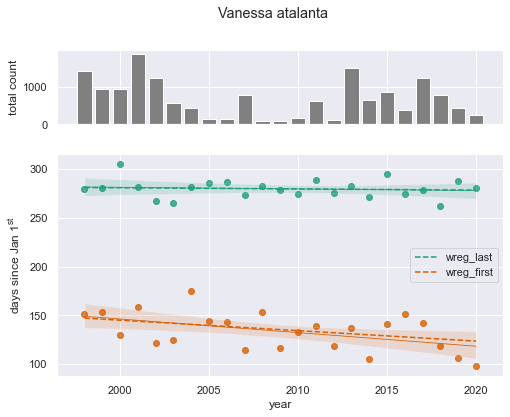

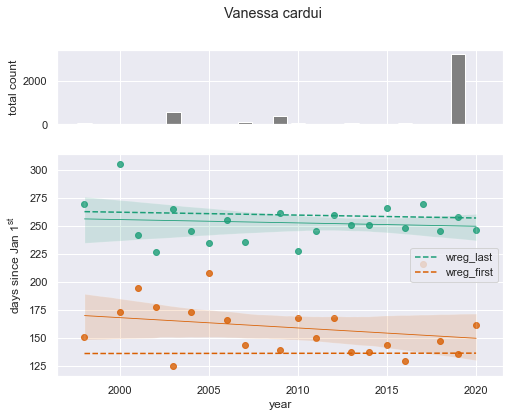

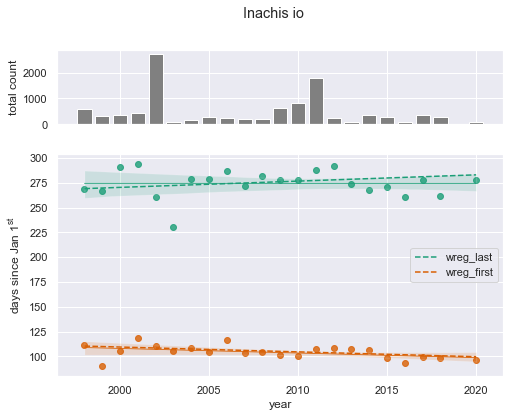

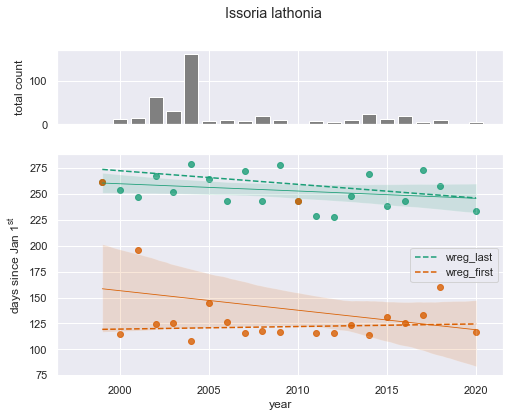

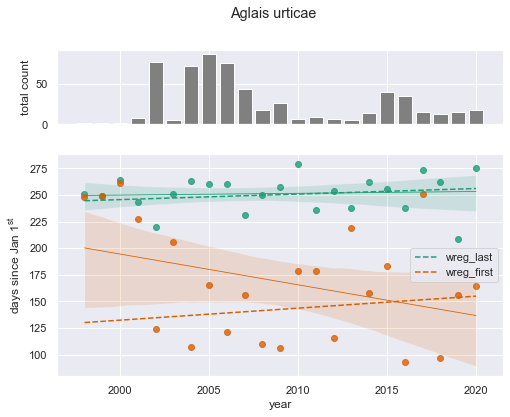

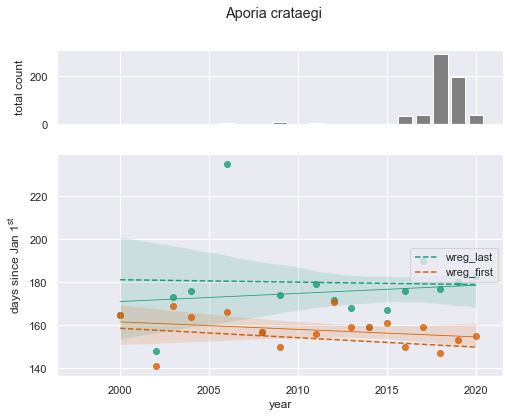

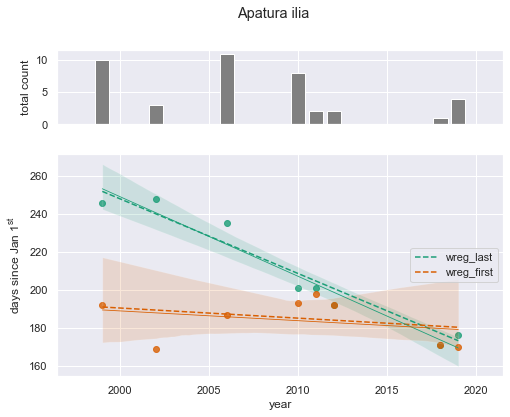

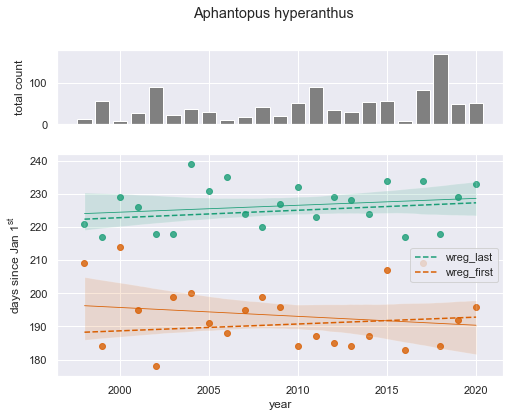

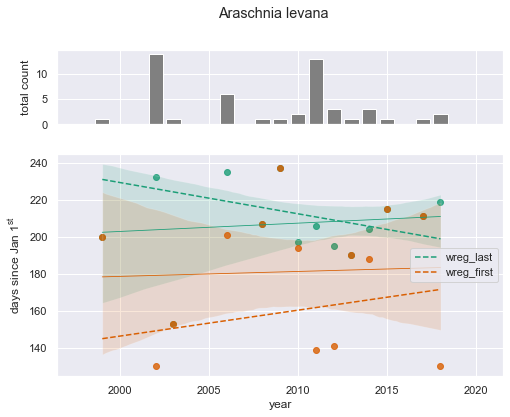

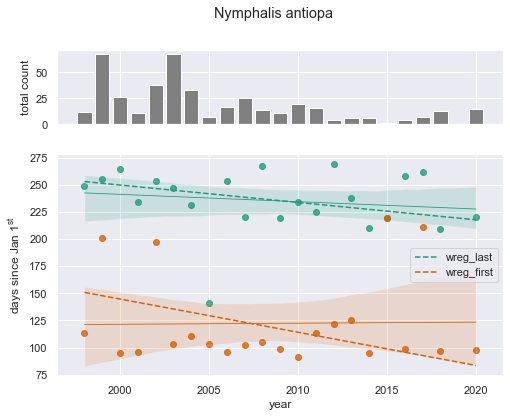

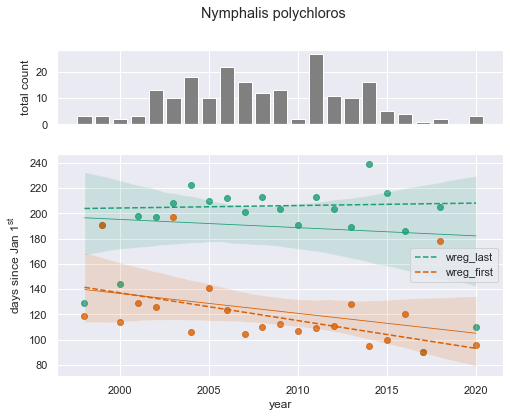

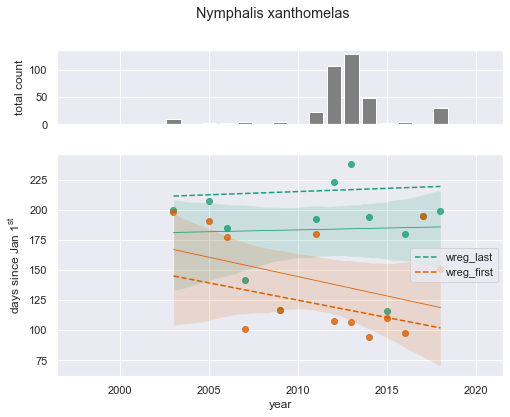

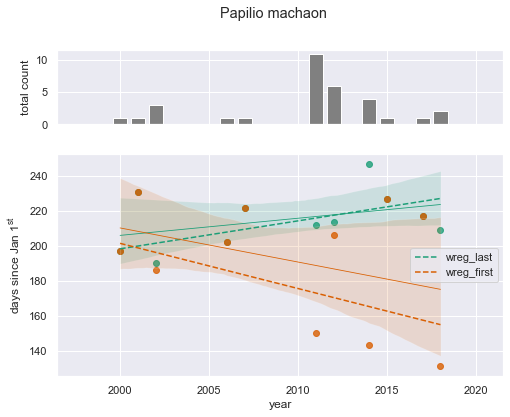

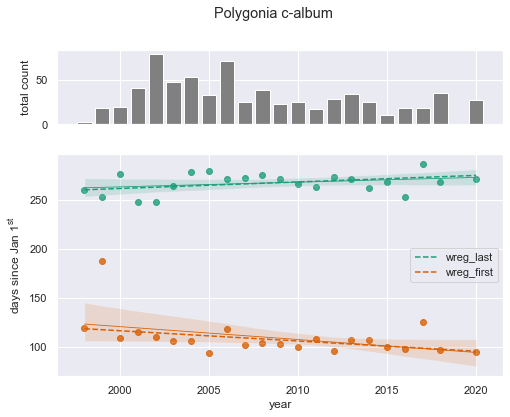

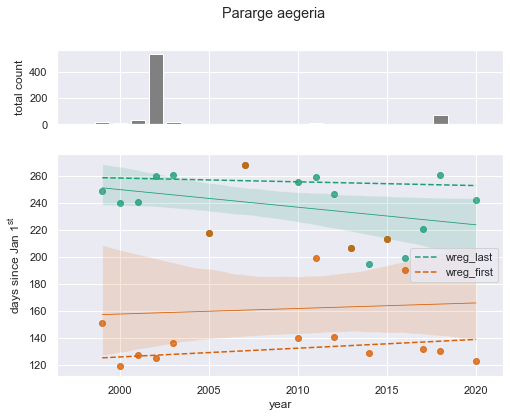

In [4]:
# PLOTTING #

# needed for accessing "Dark2" colormap (set of 8 colours)
c = np.arange(0,1,1/8)
# years as datetime object
yrs_dt = pd.date_range(start=f'1/1/{yrs[0]}',end=f'1/1/{yrs[-1]}',freq='YS').values.astype('datetime64[D]')

first, last = dict(), dict()
for s in sheets:
    df = species_summed[s]
    first[s], last[s] = first_last_day(df)
    
    # WEIGHTED LINEAR REGRESSION #
    # define index to sort out nan's
    index = np.logical_not(np.isnan(first[s]))
    X_years = yrs[index].reshape(-1,1)
    # define weights as total count per year
    wghts = total_year[s][index]
    # first day of sight
    yf = first[s][index]
    regr_first = LinearRegression()
    regr_first.fit(X=X_years, y=yf, sample_weight=wghts)
    # last day of sight
    yl = last[s][index]
    regr_last = LinearRegression()
    regr_last.fit(X=X_years, y=yl, sample_weight=wghts)
    
    # and plotting...
    f, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [1, 3]}, figsize=(8, 6))
    axs[0].bar(yrs, total_year[s], color='grey')
    #axs[0].set_yscale('log')
    axs[0].set_ylabel('total count')

    axs[1].plot(X_years, regr_last.predict(X_years), color=cm.Dark2(c[0]), ls='--')
    axs[1].plot(X_years, regr_first.predict(X_years), color=cm.Dark2(c[1]), ls='--')
    # legend refers to the previously plotted functions (!)
    axs[1].legend(labels=['wreg_last', 'wreg_first'], loc='center right') 
    sns.regplot(x=yrs, y=last[s], ax=axs[1], line_kws={'linewidth': 0.8})
    sns.regplot(x=yrs, y=first[s], ax=axs[1], line_kws={'linewidth': 0.8})
    axs[1].set_ylabel(r'days since Jan 1$^\mathregular{st}$')
    axs[1].set_xlabel('year')
    f.suptitle(f'{s}')
    f.savefig(f'../figs/first-last-day_1998-2020/species/{s}.pdf', bbox_inches='tight')

### How does the temperature look like prior to the first day of record?

In [5]:
def import_data(sheet):
    # import single dataset
    df = species[sheet].reset_index()
    # compute difference in days from Jan 1st of respective year
    df['dummy'] = [df.datetime[i] - pd.to_datetime(str(df.Year[i])+'-1-1') for i in range(len(df.index))]
    # transform difference in integers
    df['dys'] = df['dummy'].dt.days
    # and drop dummy column
    df = df.drop('dummy', axis='columns')
    df.name = sheet
    return df

va = import_data('Vanessa atalanta')
io = import_data('Inachis io')

In [6]:
# data cleaning
# remove temperature values that are higher than 50°C
va['Temp'].values[va.Temp > 50] = np.nan
# convert 'Year' values from python object to float
va['Year'] = va.Year.astype(float)
io['Year'] = io.Year.astype(float)

In [7]:
def process_data(df):
    # compute first day of sight
    first, _ = first_last_day(df)
    print(f'first days of sight of {df.name}:',first,'\n')

    # remove years without a sight
    # hence, grab indices of nan values
    i = np.argwhere(np.isnan(first))
    # update years and first day of sight accordingly
    yrs_no_nan = np.delete(yrs, i)
    first_no_nan = first[~np.isnan(first)]

    # grab indices of first day for every year
    ifirst = []
    for dy, yr in zip(first_no_nan,yrs_no_nan):
        ifirst.extend(df.loc[(df['Year'] == yr) & (df['dys'] == dy)].index.values)
    # return cleaned years, indices and year indices of nan's
    return yrs_no_nan, ifirst, i

va_yrs, va_ifirst, va_i = process_data(va)
io_yrs, io_ifirst, io_i = process_data(io)

first days of sight of Vanessa atalanta: [151. 153. 130. 159. 122. 125. 175. 144. 143. 115. 153. 117. 133. 139.
 119. 137. 105. 141. 151. 142. 119. 106.  98.] 

No counts in 2019.
first days of sight of Inachis io: [111.  90. 105. 118. 110. 105. 108. 104. 116. 103. 104. 101. 100. 107.
 108. 107. 106.  98.  93.  99.  98.  nan  96.] 



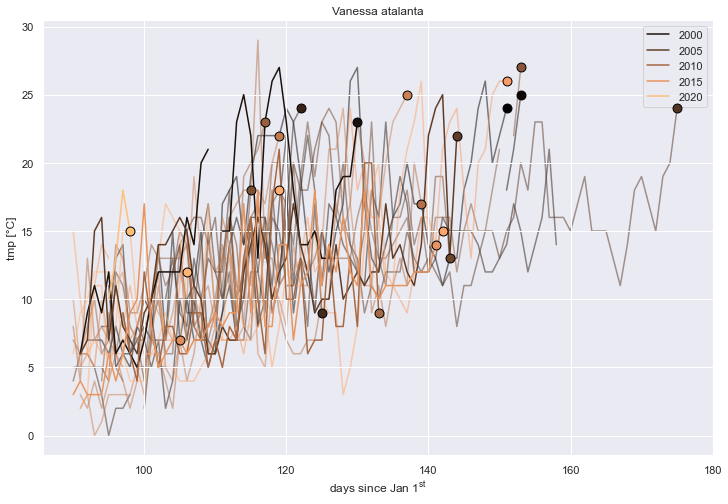

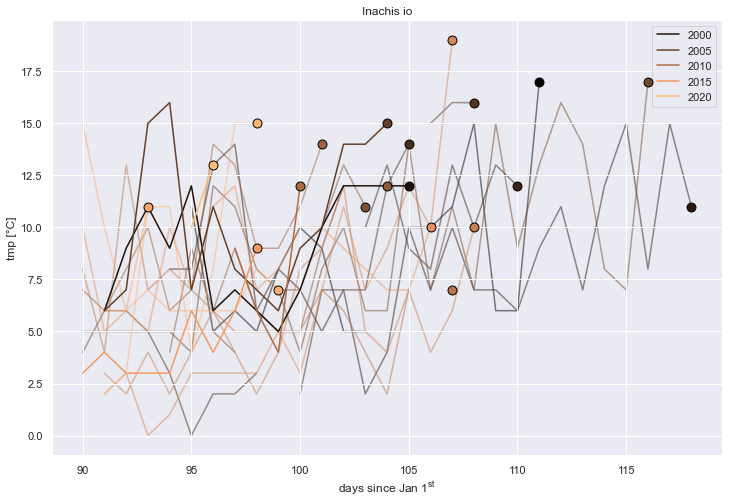

In [8]:
def visualise_data(df, yrs_no_nan, ifirst, savename):
    # adjusting continuous color mapcontinuous 
    ic = np.arange(0,1,1/len(yrs_no_nan))
    cmp = cm.copper

    fig, ax = plt.subplots(figsize=(12,8))
    # plot tmp trend up until first day of sight
    for i, yr in enumerate(yrs_no_nan):
        x = df.dys[:ifirst[i]+1][df.Year == yr].values
        y = df.Temp[:ifirst[i]+1][df.Year == yr].values
        if yr % 5 == 0:
            ax.plot(x, y, label=str(yr), color=cmp(ic[i]))
        else:
            ax.plot(x, y, color=cmp(ic[i]), alpha=0.5, zorder=0)
    # and overlay this with the day of first sight
        ax.scatter(df.dys[ifirst[i]], df.Temp[ifirst[i]], color=cmp(ic[i]), s=80,
                   edgecolor='k', zorder=10)
    # some beautification
    ax.legend()
    ax.set_xlabel(r'days since Jan 1$^{\default{st}}$')
    ax.set_ylabel('tmp [°C]')
    ax.set_title(df.name)
    if savename == 'va':
        ax.set_xlim(right=180)
    # if savename == 'io':
        # ax.set_xlim(right=125)
    fig.savefig(f'../figs/first-last-day_1998-2020/{savename}_tmp-trend_first-day_xcropped.pdf',
                bbox_inches='tight')

visualise_data(va, va_yrs, va_ifirst, 'va')
visualise_data(io, io_yrs, io_ifirst, 'io')

In [9]:
# import missing values data frame
nans = pd.read_csv('../data/missing-values.csv')

# WEIGHTED LINEAR REGRESSION
def wlinreg(X, y, wghts):
    X = X.reshape(-1,1)
    regr = LinearRegression()
    regr.fit(X=X, y=y, sample_weight=wghts)
    return regr

weights: [ 9 13 14 11  2 14  0 14 15  7 11 15  8 14 15 14 15 15 14 15 14 15 12]


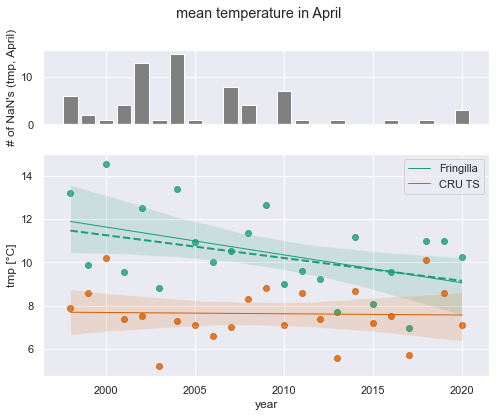

In [10]:
# plotting mean temperature of april
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 6),
                        gridspec_kw={'height_ratios': [1, 3]})
fin = 31+1

# compute mean tmp in april and standard deviation
tmp_mean_apr = np.zeros(len(yrs))
tmp_mean_apr_std = np.zeros(len(yrs))
for i, y in enumerate(yrs):
    tmp_mean_apr[i] = va.Temp[va.Year == y][:fin].mean()
    tmp_mean_apr_std[i] = va.Temp[va.Year == y][:fin].std()

# delete nan's
i = np.argwhere(np.isnan(tmp_mean_apr))
tmp_mean_apr_no_nan = np.delete(tmp_mean_apr, i)
tmp_mean_apr_std_no_nan = np.delete(tmp_mean_apr_std, i)
yrs_tmp_no_nan = np.delete(yrs, i)

nans_apr_tmp = nans.nans_apr[(nans['var'] == 'tmp') & 
                             (nans['species'] == 'Vanessa atalanta') &
                             (nans['year'] >= yrs[0])].to_numpy()
wghts = np.max(nans_apr_tmp) - nans_apr_tmp
wreg = wlinreg(yrs, tmp_mean_apr, wghts)
print('weights:',wghts)

#plt.errorbar(yrs_no_nan, tmp_mean_apr_no_nan, yerr=tmp_mean_apr_std_no_nan)
#plt.scatter(yrs, tmp_mean_apr)

# get cru ts tmp data
%store -r cru_tmp_aprl

# plotting...
# bar plot
axs[0].bar(
    yrs,
    nans_apr_tmp,
    color='grey'
)
# linear regression plot
axs[1].plot(yrs, wreg.predict(yrs.reshape(-1,1)), color=cm.Dark2(c[0]), lw=2, ls='--')
sns.regplot(x=yrs, y=tmp_mean_apr, line_kws={'linewidth': 1, 'label': 'Fringilla'}, ax=axs[1])
sns.regplot(x=yrs, y=cru_tmp_aprl, line_kws={'linewidth': 1, 'label': 'CRU TS'}, ax=axs[1])
axs[1].legend()
axs[1].set_xlabel('year')
axs[0].set_ylabel("# of NaN's (tmp, April)")
axs[1].set_ylabel('tmp [°C]')
fig.suptitle('mean temperature in April')
fig.savefig('../figs/first-last-day_1998-2020/tmp-april_per-year.pdf',
            bbox_inches='tight')

weights: [28  0 34 31 20 35  8 37 36 25 26 30 27 35 23 35 33 31 30 31 28 29 27]


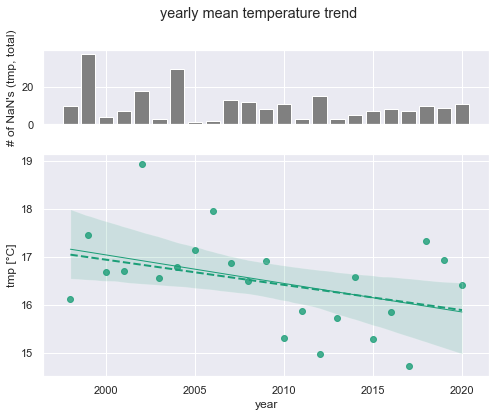

In [11]:
# plotting mean temperature of april
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 6),
                        gridspec_kw={'height_ratios': [1, 3]})

# compute mean tmp per year and standard deviation
tmp_mean = np.zeros(len(yrs))
tmp_mean_std = np.zeros(len(yrs))
for i, y in enumerate(yrs):
    tmp_mean[i] = va.Temp[va.Year == y].mean()
    tmp_mean_std[i] = va.Temp[va.Year == y].std()

nans_tmp = nans.nans_tot[(nans['var'] == 'tmp') & 
                         (nans['species'] == 'Vanessa atalanta') &
                         (nans['year'] >= yrs[0])].to_numpy()
wghts = np.max(nans_tmp) - nans_tmp
wreg = wlinreg(yrs, tmp_mean, wghts)
print('weights:',wghts)

#plt.errorbar(yrs_no_nan, tmp_mean_apr_no_nan, yerr=tmp_mean_apr_std_no_nan)
#plt.scatter(yrs, tmp_mean_apr)

# plotting...
# bar plot
axs[0].bar(
    yrs,
    nans_tmp,
    color='grey'
)
# linear regression plot
axs[1].plot(yrs, wreg.predict(yrs.reshape(-1,1)), color=cm.Dark2(c[0]), lw=2, ls='--')
sns.regplot(x=yrs, y=tmp_mean, line_kws={'linewidth': 1}, ax=axs[1])
axs[1].set_xlabel('year')
axs[0].set_ylabel("# of NaN's (tmp, total)")
axs[1].set_ylabel('tmp [°C]')
fig.suptitle('yearly mean temperature trend')
plt.show()

va weights: [10 15 15 10  1 15  0 15 15  2 15 15 15 15 15 13 15 15 15 15 13 15 15]
io weights: [10 15 15 10  1 15  0 15 15  2 15 15 15 15 15 13 15 15 15 15 13 15]


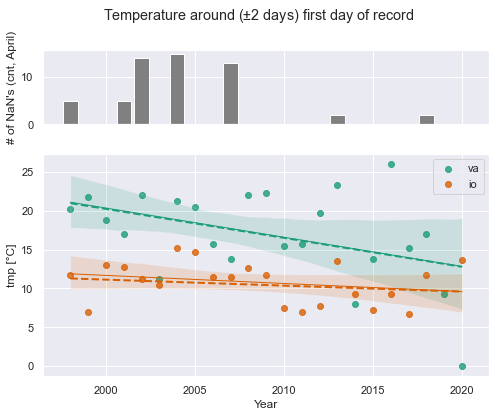

In [12]:
# create a linear regression plot of the tmp at the first day of 
# record (+/- 2 days!) in order to qualitatively identify any underlying trend...

# compute 5 day mean for va & io
va_tmpf = np.zeros(len(va_ifirst))
io_tmpf = np.zeros(len(io_ifirst))
for iva, iio in zip(range(len(va_ifirst)), range(len(io_ifirst))):
    va_tmpf[iva] = va['Temp'].iloc[va_ifirst[iva]-2:va_ifirst[iva]+2].mean()
    io_tmpf[iio] = io['Temp'].iloc[io_ifirst[iio]-2:io_ifirst[iio]+2].mean()

nans_apr_cnt = nans.nans_apr[(nans['var'] == 'cnt') & 
                             (nans['species'] == 'Vanessa atalanta') &
                             (nans['year'] >= yrs[0])].to_numpy()
va_wghts = np.delete(nans_apr_cnt, va_i)
va_wghts = np.max(va_wghts) - va_wghts
print('va weights:', va_wghts)
va_wreg = wlinreg(va_yrs, va_tmpf, va_wghts)
io_wghts = np.delete(nans_apr_cnt, io_i)
io_wghts = np.max(io_wghts) - io_wghts
print('io weights:', io_wghts)
io_wreg = wlinreg(io_yrs, io_tmpf, io_wghts)

# plotting
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 6),
                        gridspec_kw={'height_ratios': [1, 3]})
# bar plot
axs[0].bar(
    yrs,
    nans_apr_cnt,
    color='grey'
)
# linear regression plot
axs[1].plot(va_yrs, va_wreg.predict(va_yrs.reshape(-1,1)), color=cm.Dark2(c[0]), lw=2, ls='--')
axs[1].plot(io_yrs, io_wreg.predict(io_yrs.reshape(-1,1)), color=cm.Dark2(c[1]), lw=2, ls='--')
sns.regplot(data=va.loc[va_ifirst], x='Year', y=va_tmpf, ax=axs[1],
            line_kws={'linewidth': 1}, label='va')
sns.regplot(data=io.loc[io_ifirst], x='Year', y=io_tmpf, ax=axs[1],
            line_kws={'linewidth': 1}, label='io')
axs[1].legend()
axs[0].set_ylabel("# of NaN's (cnt, April)")
axs[1].set_ylabel('tmp [°C]')
fig.suptitle(r'Temperature around ($\default{\pm}$2 days) first day of record')
fig.savefig('../figs/first-last-day_1998-2020/tmp-at-first-day_per-year.pdf',
            bbox_inches='tight')